### Odysseas Sofikitis, 10130, sodyssea@ece.auth.gr
### Tompulidis Romanos, 10041, romanost@ece.auth.gr

# Helpers

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial.distance import mahalanobis
from sklearn.inspection import DecisionBoundaryDisplay
from math import pi

# calculate p(x|w_i) * p(w_i) with assumed normal distribution of p(x|w_i)
def bayes(sample, priori, mean, cov):
    distance = mahalanobis(sample, mean, np.linalg.inv(cov))
    p_x_i = 1 / (2 * pi * np.linalg.det(cov) ** (1 / 2)) * np.exp(- 1 / 2 * distance)

    return p_x_i * priori

# calculate mean of each class
def estimate_means(num_classes, num_features, train_data):
    train_x = train_data[:, 0:-1]
    train_y = train_data[:, -1]
    means = np.ones((num_classes, num_features))

    for i in range(num_classes):
        means[i, :] = np.mean(train_x[train_y == i + 1], axis=0)

    return means

# tests bayes model
def test_bayes(p, means, cov_mats, test_x, num_classes):
    pred_y = np.zeros(test_x.shape[0])

    for i in range(len(pred_y)):
        max_p = 0
        for j in range(num_classes):
            p_j = bayes(test_x[i, :], p[j], means[j, :], cov_mats[j])
            if max_p < p_j:
                max_p = p_j
                pred_y[i] = j + 1

    return pred_y

# plot decision regions and results
def plot_bayes(test_x, test_y, pred, p, means, cov_mats):
    ## get mismatches
    mismatches = test_y != pred
    pred[mismatches] = 0
    colors = {1: 'green', 2: 'purple', 3: 'yellow', 0: 'red'}

    ## plot decision regions
    h = .05
    x_min, x_max = test_x[:, 0].min() - 1, test_x[:, 0].max() + 1
    y_min, y_max = test_x[:, 1].min() - 1, test_x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    temp_x = np.stack((xx.flatten(), yy.flatten()), axis=0).T

    zz = test_bayes(p, means, cov_mats, temp_x, 3)
    plt.scatter(temp_x[:, 0], temp_x[:, 1], c=[colors[label] for label in zz])

    ## plot results
    plt.scatter(test_x[:, 0], test_x[:, 1], c=[colors[label] for label in pred], marker='o', edgecolors='k')

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10, label=f'Class {label}') for label in [1, 2, 3]]
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Missclassified'))

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(handles=legend_elements)

    plt.show()

def plot_svm(model, train_x, test_x, test_y, pred):
    support = model.support_vectors_
    matches = test_y == pred
    mismatches = test_y != pred
    colors = {
        'train': 'royalblue',
        'test-success': 'purple',
        'support': 'green',
        'test-fail': 'red'
    }

    DecisionBoundaryDisplay.from_estimator(model, train_x)
    plt.scatter(train_x[:, 0], train_x[:, 1], color='royalblue', edgecolors='k')
    plt.scatter(test_x[matches, 0], test_x[matches, 1], color='purple', edgecolors='k')
    plt.scatter(support[:, 0], support[:, 1], color='green', edgecolors='k')
    plt.scatter(test_x[mismatches, 0], test_x[mismatches, 1], color='red', edgecolors='k')

    legend_elements = [Line2D([0], [0], marker='o', color='w', \
                       markerfacecolor=colors[label], markersize=10, \
                       label=f'{label}') for label in colors]

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(handles=legend_elements)

    plt.show()
    return

# Bayes

## Data

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(filename, size):
    ## load data
    data_file = pd.read_csv(filename, header=None)
    data_file = data_file.dropna()

    # make train and test sets
    data_x = np.array(data_file.drop(data_file.columns[-1], axis=1))
    data_y = np.array(data_file[data_file.columns[-1]])

    train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,
                                                        test_size=size,
                                                        stratify=data_y,
                                                        random_state=42)

    return train_x, test_x, train_y, test_y


In [22]:
train_x, test_x, train_y, test_y = load_data("dataset.csv", 0.5)

train_data = np.concatenate([train_x, train_y.reshape(-1, 1)], axis=1)
test_data = np.concatenate([test_x, test_y.reshape(-1, 1)], axis=1)
num_features = train_x.shape[1]
num_classes = max(train_y)

## Same Covariance

Misclassified: 54 samples
Accuracy: 61.43%


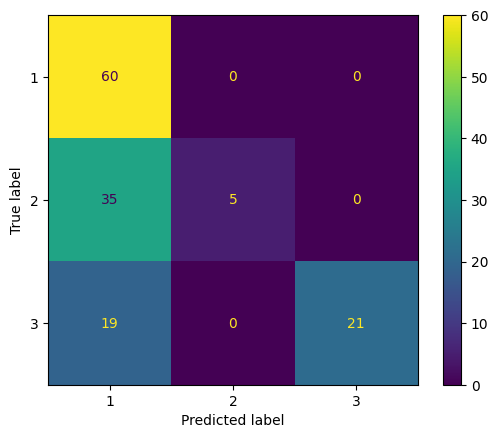

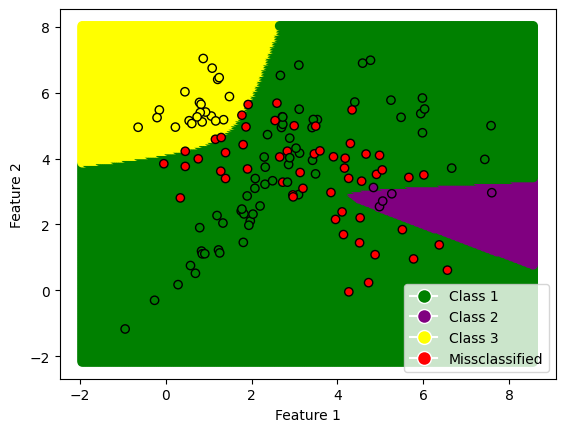

In [41]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

## maximum likelihood
# theta_1 = mean
means = estimate_means(num_classes, num_features, train_data)

# theta_2 = covariance matrix, same covariance for all classes
cov_mats = {}
for i in range(num_classes):
    cov_mats[i] = np.cov(train_x.T)


## bayes model
# a priori
p = np.ones(num_classes)
for i in range(num_classes):
    p[i] = len(train_data[train_y == i + 1]) / len(train_data)

# test model
pred = test_bayes(p, means, cov_mats, test_x, num_classes)
misses = len(pred[pred != test_y])
accuracy = accuracy_score(test_y, pred)

print("Misclassified:", misses, "samples")
print(f"Accuracy: {100 * accuracy:.2f}%")
ConfusionMatrixDisplay.from_predictions(test_y, pred)
plt.show()
plot_bayes(test_x, test_y, pred, p, means, cov_mats)

## Different Covariance

Misclassified: 25 samples
Accuracy: 82.14%


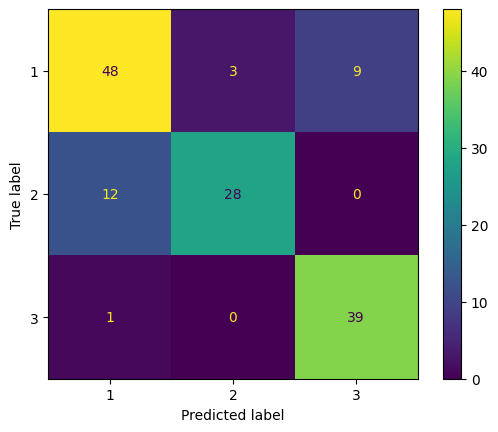

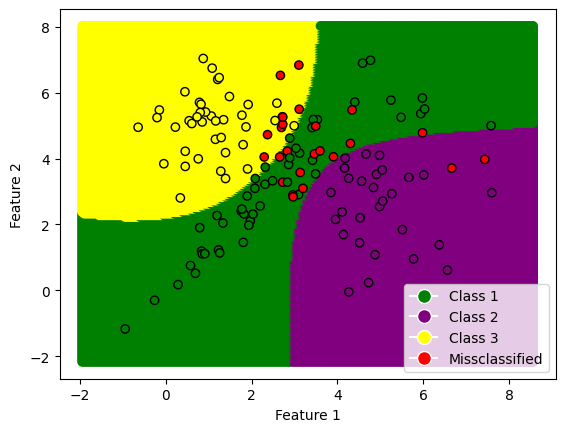

In [40]:
## different covariance matrix for each class
cov_mats = {}
for i in range(num_classes):
    cov_mats[i] = np.cov(train_x[train_y == i + 1].T)

# test model
pred = test_bayes(p, means, cov_mats, test_x, num_classes)
misses = len(pred[pred != test_y])
accuracy = accuracy_score(test_y, pred)

print("Misclassified:", misses, "samples")
print(f"Accuracy: {100 * accuracy:.2f}%")
ConfusionMatrixDisplay.from_predictions(test_y, pred)
plt.show()
plot_bayes(test_x, test_y, pred, p, means, cov_mats)

# k-NN

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay


# load data
train_x, test_x, train_y, test_y = load_data("dataset.csv", 0.5)

train_data = np.concatenate([train_x, train_y.reshape(-1, 1)], axis=1)
test_data = np.concatenate([test_x, test_y.reshape(-1, 1)], axis=1)

fig, axs = plt.subplots(5, 4, figsize=(10, 10), layout='tight')
row, col = [0, 0]
for k in range(10):
  ## K-NN to the training set
  classifier = KNeighborsClassifier(n_neighbors=k+1, weights='uniform')
  classifier.fit(train_x, train_y)

  # predict test results
  pred_y = classifier.predict(test_x)
  acc = accuracy_score(test_y, pred_y)

  ## Plots
  # Plotting the confusion matrix
  ConfusionMatrixDisplay.from_predictions(test_y, pred_y, ax=axs[row, col])
  axs[row, col].set_title('Confusion Matrix')
  col += 1

  # Plotting boundary regions
  DecisionBoundaryDisplay.from_estimator(classifier, train_x, ax=axs[row, col])
  axs[row, col].scatter(test_x[:, 0], test_x[:, 1], s=25, c=test_y, edgecolor='k')
  axs[row, col].set_title(f'k={k + 1}, error={100 * (1 - acc):.2f}%')

  col = (col + 1) % 4
  row = row + 1 if col == 0 else row

plt.show()


# SVM

In [27]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt


train_x, test_x, train_y, test_y = load_data("dataset.csv", 0.5)

train_data = np.concatenate([train_x, train_y.reshape(-1, 1)], axis=1)
test_data = np.concatenate([test_x, test_y.reshape(-1, 1)], axis=1)

## Linear

In [ ]:
## linear svm classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(train_x, train_y)

pred = svm.predict(test_x)

accuracy = accuracy_score(test_y, pred)
misses = len(pred[pred != test_y])
print("|-------------Linear SVM-------------|")
print("Misclassified:", len(pred[pred != test_y]), "samples")
print(f"Accuracy: {accuracy * 100:.2f}%\n")
plot_svm(svm, train_x, test_x, test_y, pred)
plt.show()
ConfusionMatrixDisplay.from_predictions(test_y, pred)
plt.show()

## RBF

In [ ]:
## RBF svm
print("|---------------SVM RBF--------------|")
temp_svm = SVC(kernel='rbf', random_state=42)

# hyper-parameters
parameters = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'gamma': ['auto', 0.01, 0.1, 1, 10],
}

# cv
grid = GridSearchCV(temp_svm, parameters, cv=10, n_jobs=-1)
grid.fit(train_x, train_y)
print("Best parameters:", grid.best_params_)

# predict
svm_rbf = grid.best_estimator_

pred = svm_rbf.predict(test_x)

accuracy = accuracy_score(test_y, pred)
misses = len(pred[pred != test_y])
print("Misclassified:", len(pred[pred != test_y]), "samples")
print(f"Accuracy: {accuracy * 100:.2f}%\n")
plot_svm(svm_rbf, train_x, test_x, test_y, pred)
plt.show()
ConfusionMatrixDisplay.from_predictions(test_y, pred)
plt.show()

## Default

In [ ]:
print("|---------------DEFAULT SVM--------------|")
default_svm = SVC(gamma='auto', random_state=42)

default_svm.fit(train_x, train_y)
pred = default_svm.predict(test_x)

accuracy = accuracy_score(test_y, pred)
misses = len(pred[pred != test_y])
print("Misclassified:", len(pred[pred != test_y]), "samples")
print(f"Accuracy: {accuracy * 100:.2f}%\n")
plot_svm(default_svm, train_x, test_x, test_y, pred)
plt.show()
ConfusionMatrixDisplay.from_predictions(test_y, pred)
plt.show()